# Chapter 4: Model Selection | Bias-variance Decomposition

- This Jupyter Notebook is a supplement for the [Machine Learning Simplified](https://themlsbook.com) (MLS) book. Note that all detailed explanations are written in the book. This notebook just shed light on Python implementations of the topics discussed.
- I also assume you know Python syntax and how it works. If you don't, I highly recommend you to take a break and get introduced to the language before going forward with my notebooks. 

# 0. Required Libraries & Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# 1. Synthetic Data

## 1.1. Define Synthetic Data and Target
Our synthetic problem defines:
- $f$ is the true function.  $f$ is usually not known, but for our synthetic example it is known and set to:
    $$
    f(x) = \sin(x)
    $$
- $\sigma_\epsilon$: the variance of the normally distributed observation noise $N(0, \sigma_\epsilon)$.  The observed value is equal to the  so the observation is distributed as:
    $$
    y(x) \sim f(x) + N(0, \sigma_\epsilon)
    $$
- $p(x)$ is a probability distribution over the data points $x$.  Here it is a uniform distribution on the interval $[0, 2 \pi]$
    $$
    p(x) \sim 
    \begin{cases}
        \frac{1}{2 \pi} & \text{if } x \in [0, 2 \pi] \\ % & is your "\tab"-like command (it's a tab alignment character)
        0 & \text{otherwise.}
    \end{cases}
    $$

In [34]:
x_min, x_max = 0, 2*np.pi   # range of x variable
f = lambda x: np.sin(x)     # true function
sigma_eps = 0.25            # random noise (irreducible)
N = 20             # training set size

def sample_x():
    # Sample N data points uniformly distributed on interval [x_min, x_max]
    return np.random.uniform(x_min, x_max, N)

def sample_xy():
    x = sample_x()
    y = f(x) + np.random.normal(0, sigma_eps, N)
    return x, y

### Plot two datasets
- We draw a random sample of two datasets of size $N$
- Plot them in different colors
- todo: show the true function $f$ along with it?  Say "in the synthetic example, we know the true $f$, which is the function we are trying to recover by learning from data"

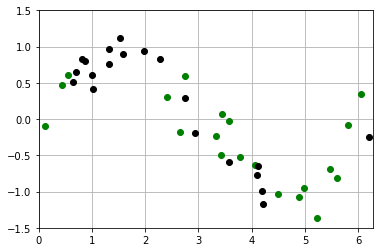

In [35]:
np.random.seed(0)

def plt_new_fig(set_axes = True):
    plt.figure()
    if set_axes:
        y_min, y_max = -1.5, 1.5    # data limits
        # y_min, y_max = -0.5, 1.5    # data limits
        plt.grid()
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

def plot_two_datasets(x1,y1, x2,y2):
    '''Plot two datasets on the same axes and set appropriate limits.'''
    plt_new_fig()
    plt.plot(x1, y1, 'og', x2, y2, 'ok')

x1, y1 = sample_xy()
x2, y2 = sample_xy()

plot_two_datasets(x1,y1, x2,y2)

### Fit polynomials of different degrees to two datasets
Note how the fit of the higher-order polynomial differs more (visually) from each other than the lower-order polynomial does.

This will visually help us understand the variance -- how much the randomness in the dataset affects the learned function $\hat{f}$.  (More detailed calculation of variance to follow)

In [49]:
t = np.linspace(x_min, x_max, 200)   # grid points - locations for plot and numeric integration
degrees_to_display = [0, 1, 3, 9]
warnings.filterwarnings("ignore")    # ingore poorly conditioned warning in polyfit


def fit_and_evaluate_polynomial(x, y, degree, locs = t):
    poly = np.poly1d(np.polyfit(x, y, degree))  # Fit polynomial to data using numpy package
    ploc = poly(locs)                           # Evaluate polynomial at grid points
    return np.clip(ploc, -10, 10)               # for numerical stability


def fit_and_plot_two_datasets(x1,y1, x2,y2, degree):
    fhat_1 = fit_and_evaluate_polynomial(x1, y1, degree)
    fhat_2 = fit_and_evaluate_polynomial(x2, y2, degree)
    
    plt_new_fig()
    plt.plot(x1, y1, 'og', t, fhat_1, '-g',
             x2, y2, 'ok', t, fhat_2, '-k')
    plt.title(f'degree = {degree}')

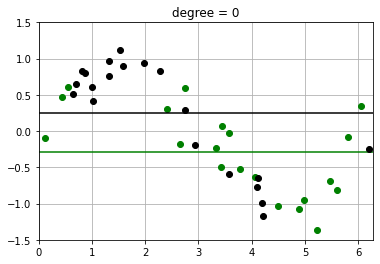

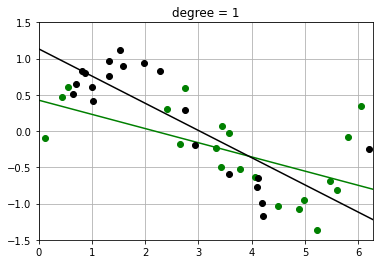

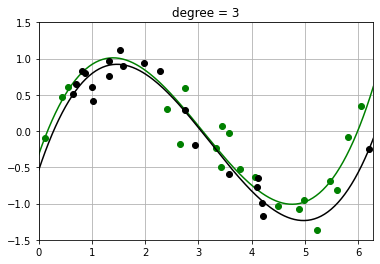

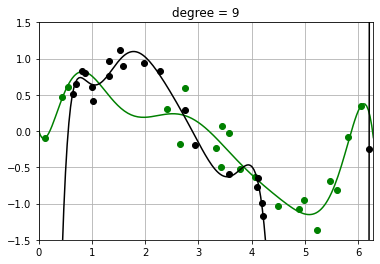

In [50]:
for degree in degrees_to_display:
    fit_and_plot_two_datasets(x1,y1, x2,y2, degree)

# 2. Variance Computation


### $E[\hat{f}]$ computation

We then approximate the expected value of the fit as the average of the fit over $M$ random dataset:
$$
E_{\mathcal{D}}[\hat{f}(x)] \ \approx \ \frac{1}{M} \sum_{i=1}^M  \hat{f}_{\mathcal{D}_i}(x)
$$
where $\hat{f}_{\mathcal{D}_i}$ is the fit to the $ith$ random dataset.

The plots below show the fits of $100$ random models and their average values,
$E_{\mathcal{D}}[\hat{f}(x)]$, for polynomials of each degree.


### Variance computation

We now compute the variance of the fits around the mean ......  todo

<!-- Note: the discrete averaging procedure is used as an approximation to the true expectation which is not easy to compute analytically. -->

In [38]:
def random_fits(degree, num_fits):
    '''Generate random datasets and fit polynomial functions to data.'''
    np.random.seed(0)
    fits = np.zeros((num_fits, len(t)))
    for i in range(num_fits):
        x, y = sample_xy()
        fits[i,:] = fit_and_evaluate_polynomial(x, y, degree)
    return fits

def compute_E_fhat(degree, num_fits = 20000):
    '''Approximate the average fit E[\hat{f}] by averaging over num_fits fits to random datasets.'''
    fits = random_fits(degree, num_fits)
    return fits.mean(axis = 0)

def compute_variance(degree, num_fits = 20000):
    fits = random_fits(degree, num_fits)
    variance_x = fits.var(axis = 0)
    variance_total = variance_x.mean()
    return variance_total

# evaluate E_fhat and variance for each polynomial degree
E_fhat   = {degree: compute_E_fhat(degree)   for degree in degrees_to_display}    
variance = {degree: compute_variance(degree) for degree in degrees_to_display}

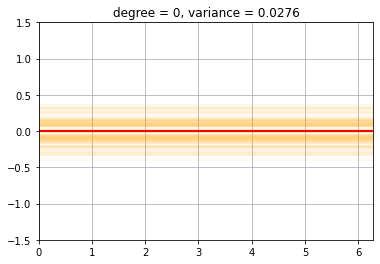

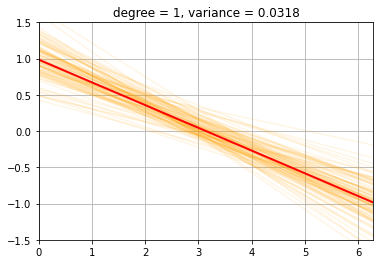

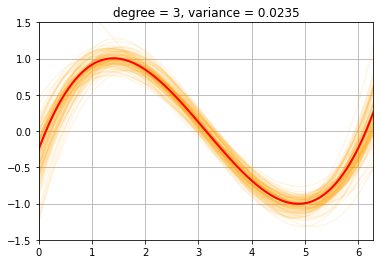

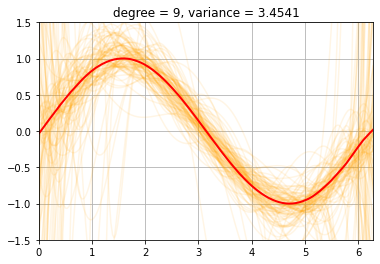

In [39]:
def plot_fits_Efhat(degree):
    fits = random_fits(degree, num_fits = 100)   # Smaller number of fits to speed up plotting
    
    plt_new_fig()
    plt.plot(t, fits.T, color = 'orange', alpha = 0.1);
    plt.plot(t, E_fhat[degree],  color = 'r', linewidth = 2, alpha = 1.0);
    plt.title(f'degree = {degree}, variance = {variance[degree]:.4f}')

for degree in degrees_to_display:
    plot_fits_Efhat(degree);

# 3. Bias Comptuation

The below plots show the expected fit $E_{\mathcal{D}}[\hat{f}]$ against the true function $f$.

We also compute the squared bias
$$
E_x\; (f(x) - E[\hat{f}(x)])^2 \; = \;
\int_{x=0}^{2 \pi}\; p(x)\; (f(x) - E[\hat{f}(x)])^2 \; = \;
\int_{x=0}^{2 \pi}\; \frac{1}{2 \pi}\; (f(x) - E[\hat{f}(x)])^2 \; \approx \;
\sum_{i=1}^{T}\; \frac{1}{|T|}\; (f(x^{(i)}) - E[\hat{f}(x^{(i)}])^2
$$
where we break up the line $[0, 2 \pi]$ into $T$ uniformly spaced discrete values, $x_1, \ldots, x_T$.

In [40]:
f_eval = f(t)   # evaluate true function f at grid points

def compute_bias_sq(degree):
    bias_sq_x = np.square(E_fhat[degree] - f_eval)
    bias_sq   = bias_sq_x.mean()  # * t_integral_area
    return bias_sq

bias_sq = {degree: compute_bias_sq(degree) for degree in degrees_to_display}

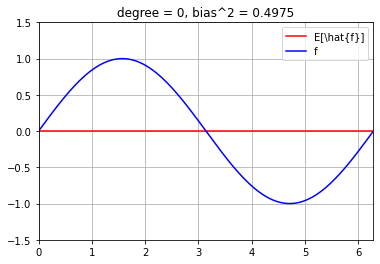

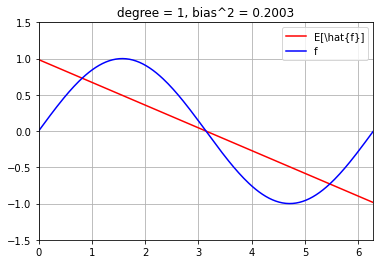

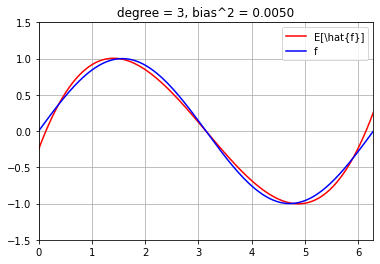

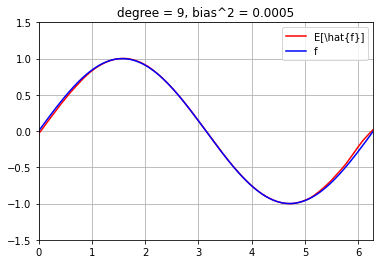

In [41]:
def plot_f_and_E_fhat(degree):
    plt_new_fig()
    plt.plot(t, E_fhat[degree], '-r', t, f_eval, '-b')
    plt.legend(['E[\hat{f}]', 'f'])
    plt.title(f'degree = {degree}, bias^2 = {bias_sq[degree]:.4f}')
    
for degree in degrees_to_display:
    plot_f_and_E_fhat(degree)

# 4. Total EPE

We now compute the total expeected prediction error (EPE) for each degree polynomial.


,Bias_Sq,Variance,Irreducible,EPE
polynomial degree,,,,
0,0.497500,0.027638,0.0625,0.587638
1,0.200318,0.031793,0.0625,0.294611
3,0.004993,0.023503,0.0625,0.090996
9,0.000483,3.454109,0.0625,3.517092


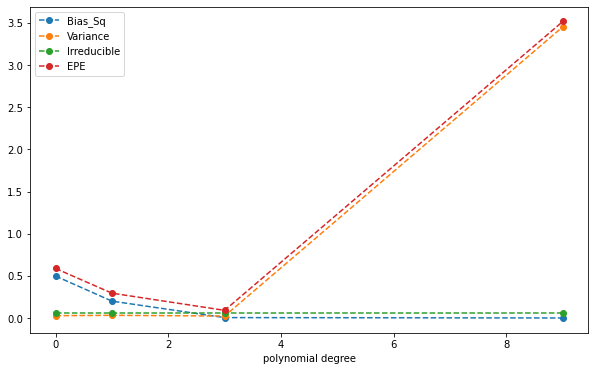

In [42]:
# Put bias, variance, irreducible error into a dataframe for easy display
import pandas as pd
irreducible = {degree: np.square(sigma_eps) for degree in degrees_to_display}
df_EPE = pd.DataFrame({'Bias_Sq': bias_sq, 'Variance': variance, 'Irreducible': irreducible})
df_EPE.index.name = 'polynomial degree'
df_EPE['EPE'] = df_EPE.sum(axis = 1)

display(df_EPE)
df_EPE.plot(linestyle = '--', marker='o', figsize = (10, 6));

# 4. Empirical Test Error

Previously we computed the theoretical EPE.
The key question is:
- Does the theoretical EPE match the emperical test error?

To compute the emperical test error, we draw a random train and test dataset,
then perform the standard ML training and evaluation procedure:

1. Draw a training set of size N
    1. Fit polynomials of each degree to the training data.
2. Draw a test set of size N
    1. Evaluate the squared error of each fit on the test data.

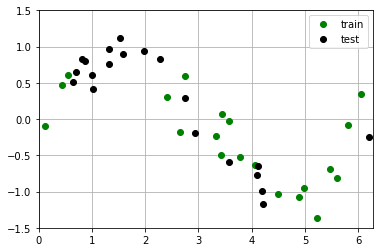

In [43]:
np.random.seed(0)

x_train, y_train = sample_xy()
x_test, y_test   = sample_xy()

plot_two_datasets(x_train, y_train, x_test, y_test)
plt.legend(['train', 'test']);

In [44]:
def fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test):
    y_pred = fit_and_evaluate_polynomial(x_train, y_train, degree,
                                         locs = x_test)
    mean_sq_err = np.square(y_pred - y_test).mean()
    return mean_sq_err

test_error = {degree: fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test)
                      for degree in degrees_to_display}
S = pd.Series(test_error, name = 'test error').to_frame()
S.index.name = 'polynomial degree'

We can see that the theoretical EPE and empirical test error agree reasonbly well.

In [45]:
pd.concat([df_EPE['EPE'], S], axis=1)

,EPE,test error
polynomial degree,,
0,0.587638,0.807306
1,0.294611,0.340867
3,0.090996,0.062224
9,3.517092,0.156872


However, the empirical error on a single dataset is obviously influenced by the random nature of the dataset.
We now compute the emperircal error by averaging over many random train and test datasets.
The emperirical error and theoretical EPE now agree *very* well.

In [46]:
def draw_sample_fit_and_eval_test_error_1(degree):
    '''
    1. Draw a random training and test set
    2. Fit a polynomial of degree degree to the tranining data
    3. Evaluate performance on test set
    '''
    x_train, y_train = sample_xy()
    x_test, y_test   = sample_xy()
    return fit_and_eval_test_error(degree, x_train, y_train, x_test, y_test)

def draw_samples_fit_and_eval_test_error(degree, num_trials = 10000):
    np.random.seed(0)
    test_errors = [draw_sample_fit_and_eval_test_error_1(degree) for _ in range(num_trials)]
    return np.mean(test_errors)

test_errors = {degree: draw_samples_fit_and_eval_test_error(degree)
               for degree in degrees_to_display}
test_errors = pd.Series(test_errors, name = 'test error').to_frame()
test_errors.index.name = 'polynomial degree'

pd.concat([df_EPE['EPE'], test_errors], axis=1)

,EPE,test error
polynomial degree,,
0,0.587638,0.589134
1,0.294611,0.291031
3,0.090996,0.090609
9,3.517092,3.426393


# 5. Conclusion

In this notebook you learned how to:
- Comptue the theoretical expected prediction error (EPE) using the bias-variance decomposition:
    - How to compute the average fit $E[\hat{f}]$
    - How to compute the **bias** of an estimator $\hat{f}$ by comparing it to the known true function $f$
    - How to compute the **variance** of an estimator
- Compare bias-variance over models of different complexity
    - Using the total EPE plots.  Note how they agree well with the "ideal" bias-variance curves shown at the beginning of the chapter.
- Theoretical EPE and emperical error agree
    - Compare the error predicted by EPE with emperical error using standard ML procedure (train and evaluate) on test data.